# Causal Explanations from Attention in Neural Networks (CLEANN)

The CLEANN algorithm relies on attention-based causal-discovery (ABCD) and the causal interpretation of self-attention to produce explanations for a pre-trained Transformer neural network. The algorithm is described in the paper: *Causal Interpretation of Self-Attention in Pre-Trained Transformers*  \[[Rohekar et al., 2023](https://arxiv.org/abs/2310.20307 "Rohekar Raanan, Gurwicz Yaniv, and Nisimov Shami. NeurIPS 2023")\], as well as  demonstrated for recommender systems in the paper: *CLEAR: Causal Explanations from Attention in Neural Recommenders* \[[Nisimov et al., 2022](https://arxiv.org/abs/2210.10621 "Nisimov Shami, Rohekar Raanan, Gurwicz Yaniv, Koren Guy, and Novik Gal. CONSEQUENCES, RecSys 2022")\]. In this notebook we will demonstrate how to use CLEANN to explain the outcome of pre-trained Transformer models. To this end, we will use a simple example. For more practical cases, such as explaining sentiment classification of movie reviews (NLP) and explaining recommendations (RecSys), please see the papers.



For running the code in this notebook two additional packages are required to be installed in the virtual environment: PyTorch and Hugging Face Transformers. We start with importing the required packages, classes, and functions.

In [25]:
from causal_reasoning import CLEANN
from plot_utils import draw_graph
from experiment_utils.explanation import exhaustive_search_explanation

import torch
from transformers import BertForMaskedLM, BertConfig, BertTokenizer, logging

from itertools import combinations
logging.set_verbosity_error()

This notebook describes three main steps:
1. [Define explanation](#define-explanation)
2. [Load a Pre-Trained Model](#load-a-pre-trained-model)
3. [Explain a Masked Token Prediction](#explain-a-masked-token-prediction)

## Define Explanation

First, let's define explanation. Given is an input sequence of tokens, where one of the tokens (called target) is masked. Then, a given model (e.g., BERT) predicts the masked target token. The goal of explanation is to identify the minimal subset of input tokens that are responsible for the predicted target token. That is, had the explanation tokens not been present, the predicted token would have been different. We seek the shortest explanation (fewest tokens), efficiently.

As an example we use the BERT base model \[[Devlin et al., 2019](https://arxiv.org/abs/1810.04805 "Jacob Devlin, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. NAACL-HLT 2019")\] for English text, and define the following. A subset of input tokens is as an explanation for the predicted target token, if by replacing the explanation tokens with '[PAD]' changes the prediction of the target.

Let's define an explanation-testing function that tests if a subset of input tokens is a valid explanation for a predicted target token. The following is a function that returns the explanation-testing function.

In [26]:
def explanation_definer(token_predictor, tokens_list, explanation_mask, prediction_mask):
    """
    A test if the given subset of the tokens can serve as an 'explanation' for the masked-token prediction.
    :param token_predictor: a function that predicts a masked token.
    :param tokens_list: a full list of tokens
    :param explanation_mask: a token that will replace the explanation tokens when testing the explanation
    :param prediction_mask: a masking token that will replace the target token when testing the explanation
    :return: a testing function with input parameters:
        explanation_token_pos: indexes of those tokens to be considered as explanation
        target_pos: index of the target node to be explained
    """
    def examine_explanation(explanation_token_pos: list, target_pos: int) -> bool:
        """
        A function for testing if a subset of tokens can serve as an explanation for the target token.
        :param explanation_token_pos: indexes of those tokens to be considered as explanation
        :param target_pos: index of the target node to be explained
        :return:
        """
        masked_tokens = tokens_list.copy()
        target_token = tokens_list[target_pos]
        masked_tokens[target_pos] = prediction_mask  # e.g., '[MASK]'
        for token_pos in explanation_token_pos:
            masked_tokens[token_pos] = explanation_mask  # e.g., '[PAD]'

        predicted_token = token_predictor(masked_tokens, target_pos)
        return predicted_token != target_token

    return examine_explanation

## Load a Pre-Trained Model
In this example, we use load the following BERT model and create a token prediction function.

In [27]:
model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name, output_attentions=True)
bert_model = BertForMaskedLM.from_pretrained(model_name, config=config)

The following is a function that takes as input a BERT model and returns a function that predicts a masked target token given a list of input tokens. 

In [28]:
def masked_token_predictor(model, tokenizer):
    """
    Creates a function that takes a list of tokens as input and predicts the masked token using the BERT model.
    :param model: a BERT model
    :param tokenizer: a corresponding tokenizer
    :return: a prediction function
    """
    def predictor(masked_tokens, target_pos):
        """
        A function that takes a list of tokens as input and predicts the masked token using the BERT model
        :param masked_tokens: list of tokens
        :param target_pos: index of the target node to be explained
        :return: the predicted token
        """
        in_ids = tokenizer.convert_tokens_to_ids(masked_tokens)
        with torch.no_grad():
            logits = model(torch.tensor([in_ids])).logits
        predicted_token_id = logits[0, target_pos].argmax(axis=-1)
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_token_id])[0]
        return predicted_token
    return predictor

token_unmasker = masked_token_predictor(bert_model, bert_tokenizer)  # create a function that predicts a masked token given a list of tokens

## Explain a Masked Token Prediction
In this example we first mask one of the tokens in a sentence, and ask the pre-trained model to predict the masked token. We then ask the CLEANN algorithm to find the minimal explanation. The example sentence is:

In [29]:
#      1   [2]  [3]   4  5   [6]     [7]    8  9   [10]  11  # index in the tokens list
txt = 'The blue whale is the largest animal on the planet.'

and the masked token is 'largest' (6th token). Our explanation should consist of only the symbolic tokens and ignore (marginalize out) tokens related to grammar.

In [30]:
target_id = 6  # the token 'largest' will be masked
nodes_of_interest = {2, 3, 6, 7, 10}  # indexes of tokens for which a graph will be learned
encoded_input = bert_tokenizer(txt, return_tensors='pt')
tokens = bert_tokenizer.convert_ids_to_tokens(encoded_input.input_ids[0])

Let's initialize the explanation testing function.

In [31]:
bert_explanation_tester = explanation_definer(token_predictor=token_unmasker, tokens_list=tokens,
                                              explanation_mask='[PAD]',
                                              prediction_mask='[MASK]')  # explanation tester

### Create a Ground Truth
Before deriving an explanation using the CLEANN algorithm we exhaustively search for all explanations and create a ground-truth list of explanations. Later, we will compare CLEANN explanations with this ground truth.

In [32]:
true_explanations_list = exhaustive_search_explanation(nodes_of_interest, target_id,
                                                          bert_explanation_tester, search_minimal=False)
for true_explanation in true_explanations_list:
    explanation_tokens = [tokens[pos] for pos in true_explanation]
    print('Exhaustive search result (ground truth):', explanation_tokens)

Exhaustive search result (ground truth): ['whale', 'animal', 'planet']
Exhaustive search result (ground truth): ['blue', 'whale', 'animal', 'planet']


The ground truth includes two explanations, where the minimal one contains three tokens at positions: 3, 7, 10, which correspond to the words '**whale**', '**animal**', and '**planet**'. Note that whether this set of words is plausible explanation to the word 'largest' in the context of the sentence is irrelevant here. It depends on multiple factors amongst which are the corpus on which the model was trained and on the training procedure. For the purpose of our example, under the given BERT model and this example's definition of explanation, it serves as ground truth.

### Find Explanations using CLEANN
Finally, let's find explanations using the CLEANN algorithm. At its heart it relies on attention-based causal-discovery (ABCD) and the causal interpretation of self-attention, as described in the [paper](https://arxiv.org/abs/2310.20307 "Causal Interpretation of Self-Attention in Pre-Trained Transformers. Rohekar, Raanan, Gurwicz Yaniv, and Nisimov Shami. NeurIPS 2023"). After learning a graph using the attention matrix, the predicted token is explained using a PDS-tree rooted at the target token. For more details on PDS-tree and its meaning see the paper: *Iterative Causal Discovery in the Possible Presence of Latent Confounders and Selection Bias* \[[Rohekar et al., 2021](https://arxiv.org/abs/2111.04095 "Rohekar, Raanan, Shami Nisimov, Yaniv Gurwicz, and Gal Novik. NeurIPS 2021")\].

Feed-forward the input sequence of tokens:

In [33]:
with torch.no_grad():
        out = bert_model(**encoded_input)

Extract attention matrices from the deepest multi-head attention layer:

In [34]:
last_mh_attention = out.attentions[-1]

Loop through all the heads and search for an explanation. For each head a new instance of CLEANN is created using that head's attention matrix. If an explanation is found, print it.

In [35]:
found_explanations = dict()
for head_id in range(last_mh_attention.shape[1]):
    attention_head = last_mh_attention[0, head_id, :, :]
    att = attention_head.numpy()  # attention matrix of current head

    # Extract explanations
    explainer = CLEANN(attention_matrix=att, num_samples=config.hidden_size, p_val_th=1e-2,
                        explanation_tester=bert_explanation_tester,
                        nodes_set=nodes_of_interest, search_minimal=False)
    
    head_explanations_list = explainer.explain(target_node_idx=target_id)
    
    found_explanations[head_id] = {'explanations': head_explanations_list,
                                    'graph': explainer.graph}

    if len(head_explanations_list) > 0:
        print('Head', head_id)
        for head_explanation in head_explanations_list:
            explanation_tokens = [tokens[pos] for pos in sorted(head_explanation[0])]
            print('>>> Found explanation:', explanation_tokens)

Head 6
>>> Found explanation: ['whale', 'animal', 'planet']
Head 8
>>> Found explanation: ['whale', 'animal', 'planet']
>>> Found explanation: ['blue', 'whale', 'animal', 'planet']


We can see that head 6 and head 8 produce the correct minimal explanation: "*The blue **whale** is the \[largest\] **animal** on the **planet**.*". We can also see that head 8 produces all the true explanations. Let's plot the corresponding graph. It represents an equivalence class in the form of a partial ancestral graph \[Richardson et al., 2002\].

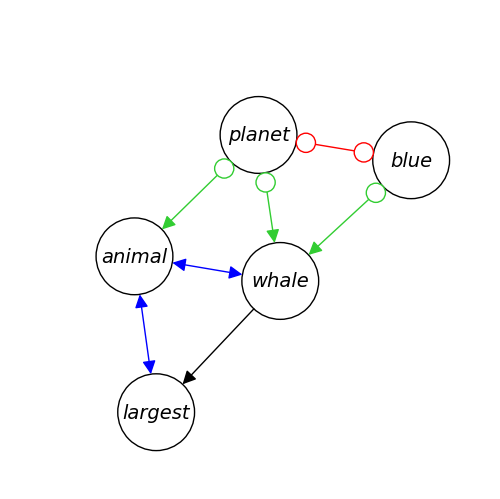

In [36]:
node_labels = {node: tokens[node] for node in range(len(encoded_input.input_ids[0]))}
fig = draw_graph(found_explanations[8]['graph'], node_labels=node_labels, node_size_factor=2.0)

## References
* Rohekar Raanan, Gurwicz Yaniv, and Nisimov Shami. "Causal interpretation of self-attention in pre-trained Transformers". Advances in Neural Information Processing Systems (NeurIPS), 2023.
* Nisimov Shami, Rohekar Raanan, Gurwicz Yaniv, Koren Guy, and Novik Gal. "CLEAR: causal explanations from attention in neural recommenders". Workshop on Causality, Counterfactuals and Sequential Decision-Making (CONSEQUENCES), Conference on Recommender Systems (RecSys), 2022.
* Jacob Devlin, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. "Bert: Pre-training of deep bidirectional transformers for language understanding". In Proceedings of NAACL-HLT, pages 4171–4186, 2019.
* Rohekar Raanan, Shami Nisimov, Yaniv Gurwicz, and Gal Novik. "Iterative causal discovery in the possible presence of latent confounders and selection bias." Advances in Neural Information Processing Systems (NeurIPS), 2021.
* Richardson Thomas, and Peter Spirtes. "Ancestral graph Markov models". The Annals of Statistics 30, no. 4, pages 962-1030, 2002.